# Simulations For Lower-Extremity Injuries Prediction Models

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display
import copy
from IPython.display import clear_output

#### Numerical Methods

##### Euler's Method

Euler's numerical method is given by the equation: $$P_{n+1}=P_n+f(t_n,P_n) \times \Delta t$$

In [185]:
def euler(f, y, dt):
        return y + dt * f

In [233]:
def euler_step(model, dt, sus, inj, rec, ret = None, *args):

    # Evaluate f(t, P) for all stocks
    new_susceptible, new_injured, new_recovered, new_retired = model(sus, inj, rec, *args)

    # Compute derivatives using Euler's method
    sus = euler(new_susceptible, sus, dt)
    inj = euler(new_injured, inj, dt)
    rec = euler(new_recovered, rec, dt)
    if ret is not None:
        ret = euler(new_retired, ret, dt)
    else: ret = None
    
    return sus, inj, rec, ret

##### Second Order Runge-Kutta Method

The second order Runge-Kutta numerical method is given by the equations:
$$Y_{n+1}=P_n+f(t_n,P_n) \times \Delta t \longrightarrow euler$$
$$P_{n+1}=P_n+\dfrac{1}{2}(f(t_n,P_n)+f(t_{n+1},Y_{n+1})) \times \Delta t$$

In [218]:
def runge_kutta_2(f, f_euler, y, dt):
    return y + 0.5 * dt * (f + f_euler)

In [232]:
def runge_kutta_step(model, dt, sus, inj, rec, ret = None, *args):

    # Evaluate f(t, P) for all populations
    new_susceptible, new_injured, new_recovered, new_retired = model(sus, inj, rec, *args)
    
    # Compute RK2's Y(n+1) for all populations --> EULER
    sus_euler = euler(new_susceptible, sus, dt)
    inj_euler = euler(new_injured, inj, dt)
    rec_euler = euler(new_recovered, rec, dt)

    # Evaluate f(t, Y(n+1)) for all populations
    rk_susceptible, rk_injured, rk_recovered, rk_retired = model(sus_euler, inj_euler, rec_euler, *args)

    # Compute RK2 values for all populations
    sus = runge_kutta_2(new_susceptible, rk_susceptible, sus, dt)
    inj = runge_kutta_2(new_injured, rk_injured, inj, dt)
    rec = runge_kutta_2(new_recovered, rk_recovered, rec, dt)
    if ret is not None:
        ret = runge_kutta_2(new_retired, rk_retired, ret, dt)
    else: ret = None
    
    return sus, inj, rec, ret

## System Dynamics Model

##### Initialize Sliders

In [3]:
# Create sliders
dt_slider = widgets.FloatLogSlider(value=0.1, min=-4, max=-1, step=0.01, description='dt:', continuous_update=False, style={'description_width': 'initial'})
simulation_length_slider = widgets.IntSlider(value=20000, min=1000, max=100000, step=1, description='Simulation length:', continuous_update=False, style={'description_width': 'initial'})
susceptible_slider = widgets.IntSlider(value=5000, min=0, max=10000, step=1, description='Initial population:', continuous_update=False, style={'description_width': 'initial'})

injury_rate_slider = widgets.FloatSlider(value=0.01, min=0, max=1, step=0.01, description='Injury rate:', continuous_update=False, style={'description_width': 'initial'})
training_rate_slider = widgets.FloatSlider(value=0.60, min=0, max=1, step=0.01, description='Training intensity:', continuous_update=False, style={'description_width': 'initial'})
rehabilitation_rate_slider = widgets.FloatSlider(value=0.02, min=0, max=1, step=0.01, description='Rehabilitation rate:', continuous_update=False,style={'description_width': 'initial'})
retire_rate_slider = widgets.FloatSlider(value=0.001, min=0, max=1, step=0.01, description='Game-ending injury rate:', continuous_update=False, style={'description_width': 'initial'})
return_to_training_slider = widgets.FloatSlider(value=0.60, min=0, max=1, step=0.01, description='Return to training rate:', continuous_update=False, style={'description_width': 'initial'})

reaction_time_slider = widgets.FloatSlider(value=0.8, min=0, max=1, step=0.01, description='Reaction time:', continuous_update=False, style={'description_width': 'initial'})

strength_slider = widgets.FloatSlider(value=0.8, min=0, max=1, step=0.01, description='Strength:', continuous_update=False, style={'description_width': 'initial'})
flexibility_slider = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description='Flexibility:', continuous_update=False, style={'description_width': 'initial'})
balance_slider = widgets.FloatSlider(value=0.85, min=0, max=1, step=0.01, description='Balance:', continuous_update=False, style={'description_width': 'initial'})
fatigue_slider = widgets.FloatSlider(value=0.03, min=0, max=1, step=0.01, description='Fatigue Rate:', continuous_update=False, style={'description_width': 'initial'})
neurocondition_slider = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description='Neurocondition:', continuous_update=False, style={'description_width': 'initial'})

workload_slider = widgets.FloatSlider(value=0.7, min=0, max=1, step=0.01, description='Workload:', continuous_update=False, style={'description_width': 'initial'})
shoe_quality_slider = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01, description='Shoe Quality:', continuous_update=False, style={'description_width': 'initial'})
humidity_slider = widgets.FloatSlider(value=0.3, min=0, max=1, step=0.01, description='Humidity:', continuous_update=False, style={'description_width': 'initial'})
temperature_slider = widgets.IntSlider(value=20, min=0, max=40, step=1, description='Temperature:', continuous_update=False, style={'description_width': 'initial'})

risk_exposure_rate_slider = widgets.FloatSlider(value=0.7, min=0, max=1, step=0.01, description='Risk exposure rate in games & practice:', continuous_update=False, style={'description_width': 'initial'})

decline_in_core_stability_slider = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Decline in core stability rate:', continuous_update=False, style={'description_width': 'initial'})

##### Setup Globals

In [223]:
display(dt_slider)
display(simulation_length_slider)
display(injury_rate_slider)
display(training_rate_slider)
display(rehabilitation_rate_slider)
display(retire_rate_slider)
display(susceptible_slider)

FloatLogSlider(value=0.1, continuous_update=False, description='dt:', max=-1.0, min=-4.0, step=0.01, style=Sli…

IntSlider(value=20000, continuous_update=False, description='Simulation length:', max=100000, min=1000, style=…

FloatSlider(value=0.01, continuous_update=False, description='Injury rate:', max=1.0, step=0.01, style=SliderS…

FloatSlider(value=0.6, continuous_update=False, description='Training intensity:', max=1.0, step=0.01, style=S…

FloatSlider(value=0.02, continuous_update=False, description='Rehabilitation rate:', max=1.0, step=0.01, style…

FloatSlider(value=0.001, continuous_update=False, description='Game-ending injury rate:', max=1.0, step=0.01, …

IntSlider(value=5000, continuous_update=False, description='Initial population:', max=10000, style=SliderStyle…

In [224]:
display(return_to_training_slider)
display(reaction_time_slider)
display(strength_slider)
display(flexibility_slider)
display(balance_slider)
display(fatigue_slider)
display(neurocondition_slider)
display(workload_slider)
display(shoe_quality_slider)
display(humidity_slider)
display(temperature_slider)
display(risk_exposure_rate_slider)
display(decline_in_core_stability_slider)

FloatSlider(value=0.6, continuous_update=False, description='Return to training rate:', max=1.0, step=0.01, st…

FloatSlider(value=0.8, continuous_update=False, description='Reaction time:', max=1.0, step=0.01, style=Slider…

FloatSlider(value=0.8, continuous_update=False, description='Strength:', max=1.0, step=0.01, style=SliderStyle…

FloatSlider(value=0.9, continuous_update=False, description='Flexibility:', max=1.0, step=0.01, style=SliderSt…

FloatSlider(value=0.85, continuous_update=False, description='Balance:', max=1.0, step=0.01, style=SliderStyle…

FloatSlider(value=0.03, continuous_update=False, description='Fatigue Rate:', max=1.0, step=0.01, style=Slider…

FloatSlider(value=0.9, continuous_update=False, description='Neurocondition:', max=1.0, step=0.01, style=Slide…

FloatSlider(value=0.7, continuous_update=False, description='Workload:', max=1.0, step=0.01, style=SliderStyle…

FloatSlider(value=0.9, continuous_update=False, description='Shoe Quality:', max=1.0, step=0.01, style=SliderS…

FloatSlider(value=0.3, continuous_update=False, description='Humidity:', max=1.0, step=0.01, style=SliderStyle…

IntSlider(value=20, continuous_update=False, description='Temperature:', max=40, style=SliderStyle(description…

FloatSlider(value=0.7, continuous_update=False, description='Risk exposure rate in games & practice:', max=1.0…

FloatSlider(value=0.5, continuous_update=False, description='Decline in core stability rate:', max=1.0, step=0…

In [4]:
dt, simulation_length, injury_rate, training_rate, rehabilitation_rate, retire_rate, susceptible, injured, recovered, retired = dt_slider.value, simulation_length_slider.value, injury_rate_slider.value, training_rate_slider.value, rehabilitation_rate_slider.value, retire_rate_slider.value, susceptible_slider.value, 0, 0, 0

return_to_training_rate, reaction_time, strength, flexibility, balance, fatigue_rate, neurocondition, workload, shoe_quality, humidity, temperature, risk_exposure_rate_in_games_and_practice, decline_in_core_stability_rate = return_to_training_slider.value, reaction_time_slider.value, strength_slider.value, flexibility_slider.value, balance_slider.value, fatigue_slider.value, neurocondition_slider.value, workload_slider.value, shoe_quality_slider.value, humidity_slider.value, temperature_slider.value, risk_exposure_rate_slider.value, decline_in_core_stability_slider.value

temperature = temperature / (40 - 20)
quality_of_movement = strength * flexibility * balance * fatigue_rate * neurocondition
internal_risk_sus = reaction_time * quality_of_movement
internal_risk_rec = reaction_time * quality_of_movement * decline_in_core_stability_rate

surface_quality = humidity * temperature
quality_of_shoe_surface_interaction = surface_quality * shoe_quality
external_risk = workload * quality_of_shoe_surface_interaction

### Simulations

##### Utility Functions

In [180]:
def update_plot(ax, sus, inj, rec, ret = None):
    clear_output(wait=True)
    ax.plot(sus, label='Susceptible', color='blue')
    ax.plot(inj, label='Injured', color='red')
    ax.plot(rec, label='Recovered', color='green')
    if ret is not None: ax.plot(ret, label='Retired', color='black')

In [231]:
def run_simulation(model, numerical_method, susceptible, injured, recovered, retired = None):
    # Initialize the figure and axes
    fig, ax = plt.subplots()
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    fig.set_size_inches(10, 6)

    # Copy initial values
    sus_euler = copy.copy(susceptible)
    inj_euler = copy.copy(injured)
    rec_euler = copy.copy(recovered)
    
    if retired is not None:
        ret_euler = copy.copy(retired)
        retired_values = [retired]
    else: ret_euler = None

    # Initialize arrays for plotting
    susceptible_values = [susceptible]
    injured_values = [injured]
    recovered_values = [recovered]

    # Run simulation
    for step in range(simulation_length):

        sus_euler, inj_euler, rec_euler, ret_euler = numerical_method(model, dt, sus_euler, inj_euler, rec_euler, ret_euler)

        susceptible_values.append(sus_euler)
        injured_values.append(inj_euler)
        recovered_values.append(rec_euler)
        if ret_euler is not None: retired_values.append(ret_euler)

        if step % 200 == 0:
            update_plot(ax, susceptible_values, injured_values, recovered_values, retired_values if ret_euler is not None else None)
            if step == 0 : ax.legend()
            display(fig)

    plt.close(fig)

#### Basic Model

Model Formulation

$$\frac{dS}{dt} = - S \times sus\_injury\_rate \times sus\_training\_intensity + Rec \times return\_to\_train$$
$$\frac{dI}{dt} = S \times sus\_injury\_rate \times sus\_training\_intensity - I \times rehab\_rate$$
$$\frac{dRec}{dt} = I \times rehab\_rate - Rec \times return\_to\_train$$

In [220]:
def injury_model_basic(susceptible, injured, recovered, inj_rate = injury_rate, train_rate = training_rate, rehab_rate = rehabilitation_rate, return_to_train = return_to_training_rate):
    ds_dt = - susceptible * inj_rate * train_rate + recovered * return_to_train
    di_dt = susceptible * inj_rate * train_rate - injured * rehab_rate
    drec_dt = injured * rehab_rate - recovered * return_to_train

    return ds_dt, di_dt, drec_dt, None

Simulation Using Euler

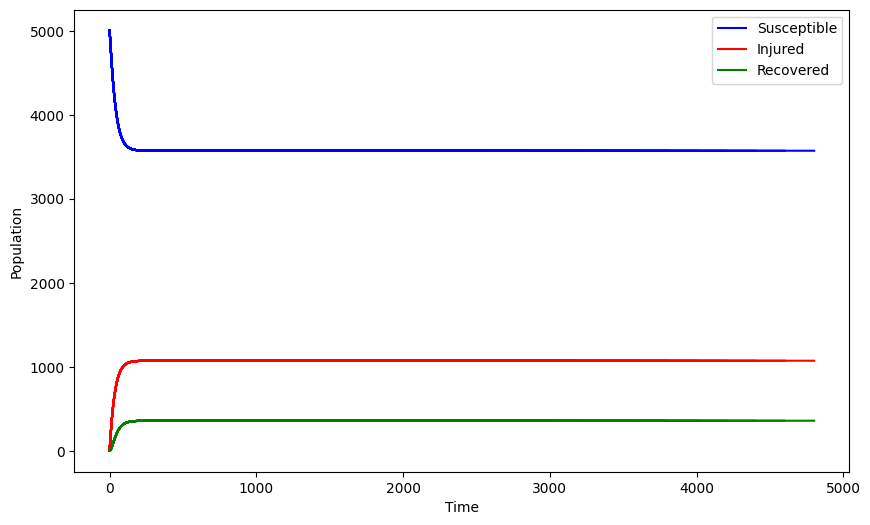

In [207]:
run_simulation(injury_model_basic, euler_step, susceptible, injured, recovered)

Simulation Using Runge-Kutta 2

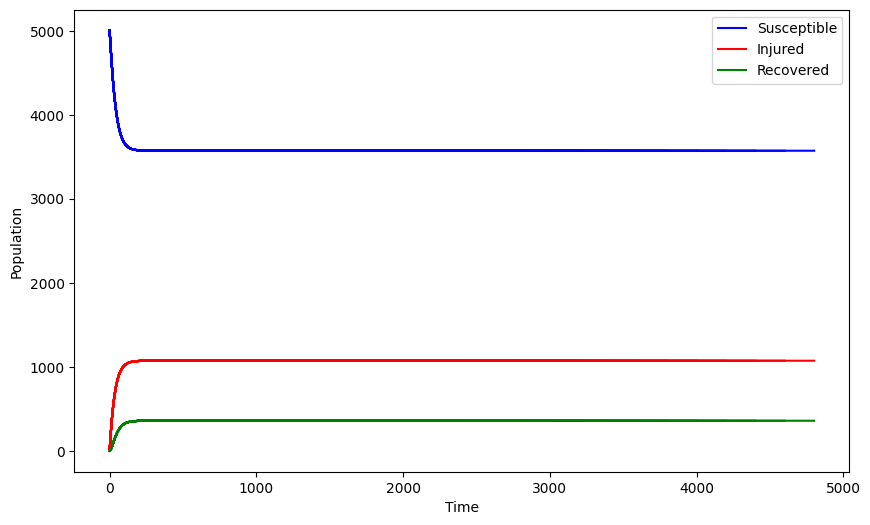

In [221]:
run_simulation(injury_model_basic, runge_kutta_step, susceptible, injured, recovered)

#### Complex Model

Model Formulation
$$\frac{dS}{dt} = - S \times sus\_internal\_risk \times external\_risk \times risk\_exposure\_in\_games$$
###### $$\frac{dI}{dt} = S \times sus\_internal\_risk \times external\_risk \times risk\_exposure\_in\_games + Rec \times rec\_internal\_risk \times external\_risk \times risk\_exposure\_in\_games - I \times rehab\_rate - I \times retire\_rate$$
$$\frac{dRec}{dt} = I \times rehab\_rate - Rec \times rec\_internal\_risk \times external\_risk \times risk\_exposure\_in\_games$$
$$\frac{dRet}{dt} = I \times retire\_rate$$

In [229]:
def injury_model_complex(susceptible, injured, recovered, int_risk_sus = internal_risk_sus, int_risk_rec = internal_risk_rec, ext_risk = external_risk, risk_exposure = risk_exposure_rate_in_games_and_practice, rehab_rate = rehabilitation_rate, ret_rate = retire_rate):
    ds_dt = - susceptible * int_risk_sus * ext_risk * risk_exposure
    di_dt = susceptible * int_risk_sus * ext_risk * risk_exposure + recovered * int_risk_rec * ext_risk * risk_exposure - injured * rehab_rate - injured * ret_rate
    drec_dt = injured * rehab_rate - recovered * int_risk_rec * ext_risk * risk_exposure
    dret_dt = injured * ret_rate

    return ds_dt, di_dt, drec_dt, dret_dt

Simulation Using Euler

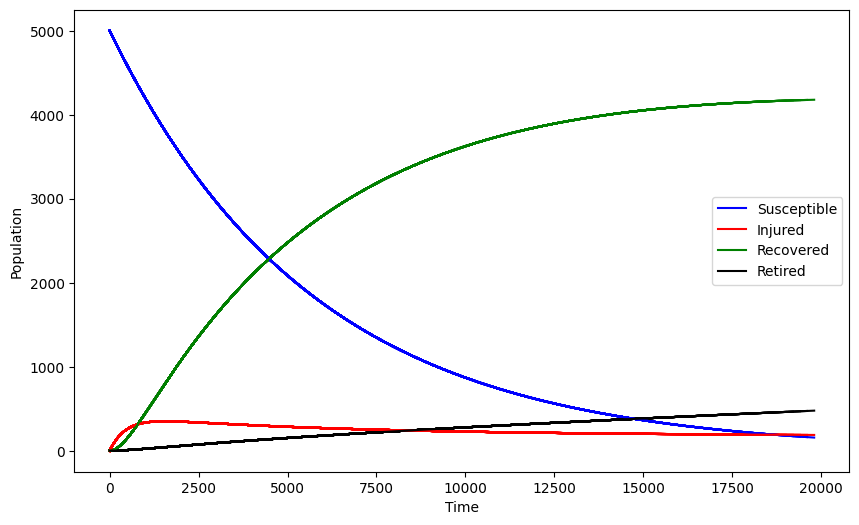

In [234]:
run_simulation(injury_model_complex, euler_step, susceptible, injured, recovered, retired)

Simulation Using Runge-Kutta 2

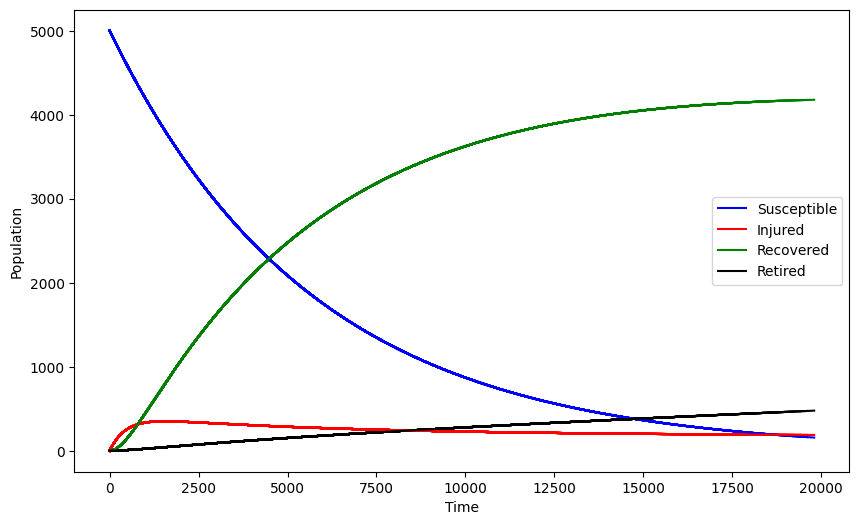

In [230]:
run_simulation(injury_model_complex, runge_kutta_step, susceptible, injured, recovered, retired)

#### Simulation Using Monte Carlo

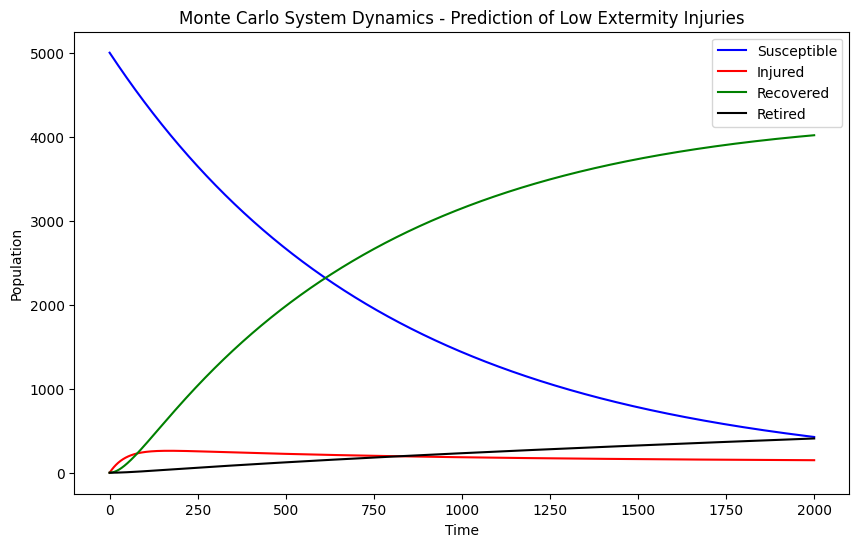

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#differential equations
def model(y, t, int_risk_sus, ext_risk, risk_exposure, int_risk_rec, rehab_rate, ret_rate):
    susceptible, injured, recovered, retired = y
    
    dsdt = - susceptible * int_risk_sus * ext_risk * risk_exposure
    didt = susceptible * int_risk_sus * ext_risk * risk_exposure + recovered * int_risk_rec * ext_risk * risk_exposure - injured * rehab_rate - injured * ret_rate
    drdt = injured * rehab_rate - recovered * int_risk_rec * ext_risk * risk_exposure
    drretdt = injured * ret_rate
    
    return [dsdt, didt, drdt, drretdt]

#monte carlo parameters
simulations = 5
np.random.seed(42)  


#time steps
t = np.arange(0, simulation_length / 10, dt)

#initializing arrays for the results
sus_average, inj_average, rec_average, ret_average = np.zeros_like(t), np.zeros_like(t), np.zeros_like(t), np.zeros_like(t)

#monte carlo simulations
for _ in range(simulations):
    #random variations
    mc_sus_injury_rate = injury_rate + (injury_rate / 10) * np.random.randn()
    mc_sus_training_rate = training_rate + (training_rate / 10) * np.random.randn()
    mc_rehab_rate = rehabilitation_rate + (rehabilitation_rate / 10) * np.random.randn()
    mc_ret_rate = retire_rate + (retire_rate / 10) * np.random.randn()

    mc_temp = temperature + (temperature / 10) * np.random.randn()
    mc_humidity = humidity + (humidity / 10) * np.random.randn()
    mc_risk_exposure_rate_in_games_and_practice = risk_exposure_rate_in_games_and_practice + (risk_exposure_rate_in_games_and_practice / 10) * np.random.randn()
    mc_decline_in_core_stability_rate = decline_in_core_stability_rate + (decline_in_core_stability_rate / 10) * np.random.randn()

    mc_return_to_training_rate = return_to_training_rate + (return_to_training_rate / 10) * np.random.randn()
    mc_reaction_time = reaction_time + (reaction_time / 10) * np.random.randn()
    mc_strength = strength + (strength / 10) * np.random.randn()
    mc_flexibility = flexibility + (flexibility / 10) * np.random.randn()
    mc_balance = balance + (balance / 10) * np.random.randn()
    mc_fatigue_rate = fatigue_rate + (fatigue_rate / 10) * np.random.randn()
    mc_neurocondition = neurocondition + (neurocondition / 10) * np.random.randn()
    mc_workload = workload + (workload / 10) * np.random.randn()
    mc_shoe_quality = shoe_quality + (shoe_quality / 10) * np.random.randn()
    
    mc_quality_of_movement = mc_strength * mc_flexibility * mc_balance * mc_fatigue_rate * mc_neurocondition
    mc_internal_risk_sus = mc_reaction_time * mc_quality_of_movement
    mc_internal_risk_rec = mc_reaction_time * mc_quality_of_movement * mc_decline_in_core_stability_rate

    mc_surface_quality = mc_humidity * mc_temp
    mc_quality_of_shoe_surface_interaction = mc_surface_quality * mc_shoe_quality
    mc_external_risk = mc_workload * mc_quality_of_shoe_surface_interaction

    #initial conditions for each starting from zero recovered and zero retired
    initial_conditions = [susceptible, injured, recovered, retired]

    #solving the system
    result = odeint(model, initial_conditions, t, args=(mc_internal_risk_sus, mc_external_risk, mc_risk_exposure_rate_in_games_and_practice, mc_internal_risk_rec, mc_rehab_rate, mc_ret_rate))

    #accumlating the results
    sus_average += result[:, 0]
    inj_average += result[:, 1]
    rec_average += result[:, 2]
    ret_average += result[:, 3]

#averaging the results over number of simulations (5)
sus_average /= simulations
inj_average /= simulations
rec_average /= simulations
ret_average /= simulations

#plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, sus_average, label='Susceptible', color='b')
plt.plot(t, inj_average, label='Injured', color='r')
plt.plot(t, rec_average, label='Recovered', color='g')
plt.plot(t, ret_average, label='Retired', color='black')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Monte Carlo System Dynamics - Prediction of Low Extermity Injuries')
plt.legend()
plt.show()


### Regression Model

##### Logistic Regression Model
$$\hat{y} = \frac{1}{1 + e^{-X\theta}}$$

In [ ]:
def logistic_regression(X, theta):
    z = np.dot(X, theta)
    # Use np.clip to avoid values that lead to numerical instability
    z = np.clip(z, -20, 20)
    return 1 / (1 + np.exp(-z))

##### Compute Gradient
$$\nabla_\theta J(\theta) = \frac{1}{m} X^T(\hat{y} - y)$$

In [ ]:
def compute_gradient_logistic(X, y, theta):
    predictions = logistic_regression(X, theta)
    error = predictions - y
    gradient = np.dot(X.T, error) / len(y)
    return gradient

##### Compute Loss
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})]$$

In [ ]:
def logistic_loss(X, y, theta):
    predictions = logistic_regression(X, theta)
    # Clip predictions to avoid log(0)
    eps = 1e-15
    predictions = np.clip(predictions, eps, 1 - eps)
    return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

##### Gradient Descent using Euler Method

In [ ]:
def gradient_descent_euler_logistic(X, y, theta, learning_rate, iterations):
    history = []  # to store the history of the cost function
    for _ in range(iterations):
        grad = compute_gradient_logistic(X, y, theta)

        #! TRY THIS
        # theta = euler(grad, theta, learning_rate)
        theta = theta - learning_rate * grad

        history.append(logistic_loss(X, y, theta))
    return theta, history

##### Gradient Descent using Runge-Kutta 2nd Order Method

In [ ]:
import numpy as np
import pickle
import time
def gradient_descent_runge_kutta_2_logistic(X, y, theta, learning_rate, iterations):

    history = []  # to store the history of the cost function

    for _ in range(iterations):

        #! TRY THIS
        # euler_theta = euler(compute_gradient_logistic(X, y, theta), theta, learning_rate)
        # theta = runge_kutta_2(compute_gradient_logistic(X, y, theta), compute_gradient_logistic(X, y, euler_theta), theta, learning_rate)

        k1 = compute_gradient_logistic(X, y, theta)
        k2 = compute_gradient_logistic(X, y, theta - learning_rate * k1)
        theta = theta - (learning_rate / 2) * (k1 + k2)

        history.append(logistic_loss(X, y, theta))
    return theta, history

##### Simulation

### Loading and Splitting Data

In [ ]:
def load_data():
    with open('../data/running/pickles/X.pkl', 'rb') as f:
        X = pickle.load(f)
    with open('../data/running/pickles/y.pkl', 'rb') as f:
        y = pickle.load(f)

    #convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X, y

from sklearn.model_selection import train_test_split

X, y = load_data() # load data
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y) # split data 
print("Data loaded successfully.")
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

print("Summary of data:")
print("Number of training examples: ", X_train.shape[0])
print("Number of test examples: ", X_test.shape[0])

ModuleNotFoundError: No module named 'pandas'

Learning rate:  0.01  Iterations:  100  Loss:  9.816582406347727
Learning rate:  0.01  Iterations:  200  Loss:  9.760115975212468


Learning rate:  0.01  Iterations:  500  Loss:  9.640354683823173
Learning rate:  0.01  Iterations:  1000  Loss:  9.570036573172846
Learning rate:  0.01  Iterations:  2000  Loss:  9.33333331879732
Learning rate:  0.01  Iterations:  10000  Loss:  9.045028372508485
Learning rate:  0.05  Iterations:  100  Loss:  9.429218216590238
Learning rate:  0.05  Iterations:  200  Loss:  8.731127700217582
Learning rate:  0.05  Iterations:  500  Loss:  8.636035099520477
Learning rate:  0.05  Iterations:  1000  Loss:  9.275362304256479
Learning rate:  0.05  Iterations:  2000  Loss:  9.565217376200083
Learning rate:  0.05  Iterations:  10000  Loss:  9.0604215040333
Learning rate:  0.1  Iterations:  100  Loss:  9.623188390588805
Learning rate:  0.1  Iterations:  200  Loss:  9.768115926560606
Learning rate:  0.1  Iterations:  500  Loss:  9.565217376200083
Learning rate:  0.1  Iterations:  1000  Loss:  9.130434768284678
Learning rate:  0.1  Iterations:  2000  Loss:  9.188405782673398
Learning rate:  0.1  It

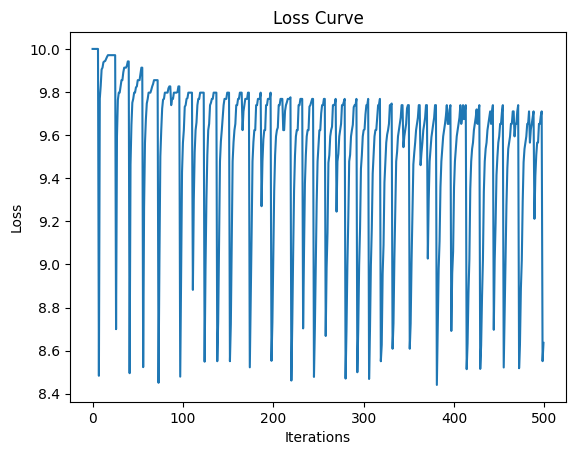

Training and tuning completed. Results: (array([ 1.20748967e+00, -3.93121834e+00, -6.75820472e+00,  1.08717954e+01,
        5.78440776e-01,  1.05131151e+00,  5.63273685e+00,  3.03258177e+00,
        3.08342122e+00,  9.65419008e-01,  3.82691634e-01,  4.40515795e-01,
        8.62293303e-01, -2.90370995e+00, -5.96805972e+00, -1.50221812e+00,
        3.18946784e+00,  2.09605063e-01,  1.58516967e-01,  9.32401261e-01,
        1.01827787e-01, -1.16297746e-01,  8.10879078e-01, -1.20456762e+00,
        1.24151069e+00, -1.02604106e+00, -1.42299533e+00, -2.41754538e+01,
       -5.03526941e+00,  4.90626474e-01, -6.41119766e-03, -4.50628754e-01,
       -1.24512261e+00, -1.29469191e-01, -5.28219944e-02, -3.94751428e-02,
       -3.49340055e-01,  5.36590716e-01,  5.91174718e+00,  9.59039028e+00]), [10.000000002061155, 10.000000002061155, 10.000000002061155, 10.000000002061155, 10.000000002071188, 10.000000010846765, 10.000005922048995, 8.4832638459953, 9.76965491747939, 9.828515983209481, 9.9046251453

In [ ]:


def train_model(X_train, y_train, theta_initial, learning_rate, iterations, method='euler', early_stopping_rounds=100):
    # Assume early_stopping_rounds is the number of rounds without improvement to stop
    min_loss = np.inf
    no_improvement_rounds = 0

    # Initialize theta
    theta = theta_initial

    # Initialize history
    history = []

    # Train model
    if method == 'euler':
        theta, history = gradient_descent_euler_logistic(
            X_train, y_train, theta, learning_rate, iterations)
    elif method == 'runge_kutta_2':
        theta, history = gradient_descent_runge_kutta_2_logistic(
            X_train, y_train, theta, learning_rate, iterations)
    else:
        raise ValueError("Method not supported.")


        

    # Return the final model parameters and history
    return theta, history

def hyperparameter_tuning(X_train, y_train, theta_initial, learning_rates, iterations_list, method= 'euler'):
    min_loss = np.inf
    best_params = {'learning_rate': 0, 'iterations': 0,
                   'method': '', 'theta': [], 'history': []}

    for learning_rate in learning_rates:
        for iterations in iterations_list:
            
            # Train model
            theta, history = train_model(
                X_train, y_train, theta_initial, learning_rate, iterations, method)
            
            # Compute loss
            current_loss = history[-1]

            # Update best parameters
            if current_loss < min_loss:
                min_loss = current_loss
                best_params['learning_rate'] = learning_rate
                best_params['iterations'] = iterations
                best_params['method'] = method
                best_params['theta'] = theta
                best_params['history'] = history
            
            print("Learning rate: ", learning_rate , " Iterations: ", iterations, " Loss: ", current_loss)


    return best_params


def train_and_tune_model(X_train, y_train, theta_initial, learning_rates, iterations_list,method,  tune_hyperparams=True):
    if tune_hyperparams:
        best_dict =  hyperparameter_tuning(X_train, y_train, theta_initial, learning_rates, iterations_list, method)
        theta = best_dict['theta']
        history = best_dict['history']
    else:
        learning_rate = 1
        iterations = 100000
        theta, history = train_model(
            X_train, y_train, theta_initial, learning_rate, iterations, method)
    # draw loss curve for each learning rate and iterations
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()

    return theta, history


# Initial parameters
theta_initial = np.zeros(X_train.shape[1])

# Train and tune model
results = train_and_tune_model(X_train, y_train, theta_initial, [
                               0.01, 0.05, 0.1, 0.5, 1,5], [100, 200, 500, 1000, 2000,10000], 'runge_kutta_2', tune_hyperparams=True)
print("Training and tuning completed. Results:", results)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming logistic_regression is your model function
# and X, y are your features and labels
# print("Training model on full training data...")
# print ("X_train summary: ", X_train.shape)
# print(X_train[:5])
# print ("y_train summary: ", y_train.shape)
# print(y_train)
# print ("X_test summary: ", X_test.shape)
# print(X_test[:5])
# print ("y_test summary: ", y_test.shape)
# print(y_test[:5])


# Set up cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
optimal_thresholds = []

for train_index, test_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    # Train your model on the training data
    # Replace with your training function
    best_theta = train_model(X_train, y_train, theta_initial, 0.05, 1000, 'euler')[0]

    # Initialize lists for this fold
    thresholds = np.arange(0, 1, 0.01)
    f1_scores = []

    # Find the optimal threshold for this fold
    for threshold in thresholds:
        y_pred = logistic_regression(X_val, best_theta) >= threshold
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)

    # Find and store the optimal threshold for this fold
    optimal_idx = np.argmax(f1_scores)
    optimal_thresholds.append(thresholds[optimal_idx])

# Calculate the average optimal threshold
avg_optimal_threshold = np.mean(optimal_thresholds)


# Plotting (if you have loss history)
# plt.plot(history_euler, label='Euler')
# plt.plot(history_rk2, label='Runge-Kutta 2')
# plt.xlabel('Iterations')
# plt.ylabel('Logistic Loss')
# plt.title('Loss History')
# plt.legend()
# plt.show()

In [ ]:
# Train model on full training data and evaluate on test data
best_theta_final = train_model(
    X_train, y_train, theta_initial, 0.05, 1000, 'euler', early_stopping_rounds=1000)[0]
y_pred_final = logistic_regression(
    X_test, best_theta_final) >= avg_optimal_threshold
accuracy_final = accuracy_score(y_test, y_pred_final)

# Print results
print("Average Optimal Threshold:", avg_optimal_threshold)
print("Final Model Accuracy:", accuracy_final)

Average Optimal Threshold: 0.018000000000000002
Final Model Accuracy: 0.5239130434782608


In [ ]:
# Visualize predictions and their accuracy on the test set

# Plot the decision boundary
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
x1 = np.linspace(-2, 2, 10)
x2 = -(theta_euler[0] + theta_euler[1] * x1) / theta_euler[2]

plt.figure(figsize=(12, 8))
plt.plot(x1, x2, label='Euler')

x2 = -(theta_rk2[0] + theta_rk2[1] * x1) / theta_rk2[2]
plt.plot(x1, x2, label='Runge-Kutta 2')



# Plot the accuracy
plt.figure(figsize=(12, 8))
plt.plot(history_euler, label='Euler')
plt.plot(history_rk2, label='Runge-Kutta 2')
plt.xlabel('Iterations')
plt.ylabel('Logistic Loss')
plt.title('Loss History')
plt.legend()
plt.show()



# Get coefficients and intercept from the model
weights = theta_euler[1:]
intercept = theta_euler[0]

# Calculate probabilities for each observation in X_test
linear_combination = np.dot(X_test, weights.T) + intercept
#import sigmoid
from scipy.special import expit
probabilities = expit(linear_combination)

# probabilities = sigmoid(linear_combination)

# For each feature, plot the distribution of probabilities for each class
n_features = X_test.shape[1]
for i in range(n_features):
    plt.figure(figsize=(8, 6))
    sns.histplot(probabilities[y_test == 0, i],
                 color='red', label='Class 0', kde=True)
    sns.histplot(probabilities[y_test == 1, i],
                 color='blue', label='Class 1', kde=True)
    plt.title(f'Probability Distribution for Feature {i}')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

        





NameError: name 'theta_euler' is not defined